# 巅峰实战：从零开始构建手写数字识别神经网络

欢迎来到我们学习之旅的最终章！在前面的8个Notebook中，我们已经通过直觉和简单的例子，掌握了神经网络背后的核心数学原理。现在，是时候将这些知识融会贯通，解决一个真实世界的问题了。

**我们的目标：** 不使用任何现成的深度学习框架（如PyTorch或TensorFlow的核心模型部分），仅依靠`Numpy`，从零开始构建一个能够识别MNIST手写数字的神经网络。

**你将亲眼见证：**
1.  真实的图像数据如何被预处理成网络可以理解的格式。
2.  我们之前学到的所有数学概念（向量、矩阵、激活函数、损失函数、反向传播、梯度下降）如何协同工作。
3.  一个“无知”的网络如何通过训练，变得越来越“聪明”，最终能够准确识别出你写的数字。

## 第1步：准备数据 (MNIST Dataset)

MNIST是一个包含了大量手写数字图片的数据集，是机器学习领域的“入门圣经”。每张图片都是一个28x28像素的灰度图，并带有一个0-9的标签。

为了方便，我们将使用`scikit-learn`这个库来下载和加载数据。它是为数不多的、我们依赖的外部库之一，主要用于数据处理。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
# 加载数据，这可能需要几分钟时间
print("正在加载MNIST数据集...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
print("数据集加载完毕!")

# --- 数据预处理 ---

# 1. 归一化像素值
# 原始像素值在0-255之间，我们将其缩放到0-1之间，这有助于训练的稳定性和速度
X = X / 255.0

# 2. 转换标签为独热编码 (One-Hot Encoding)
# 原始标签是 '0', '1', ..., '9'。我们需要将其转换为向量形式。
# 例如: '2' -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
# '7' -> [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
# 这样做是为了方便计算损失
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# 3. 划分训练集和测试集
# 我们用大部分数据来训练模型，留一小部分数据来测试模型的泛化能力
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.1, random_state=42)

print(f"训练数据形状: {X_train.shape}")
print(f"测试数据形状: {X_test.shape}")
print(f"训练标签形状: {y_train.shape}")
print(f"测试标签形状: {y_test.shape}")

正在加载MNIST数据集...
数据集加载完毕!
训练数据形状: (63000, 784)
测试数据形状: (7000, 784)
训练标签形状: (63000, 10)
测试标签形状: (7000, 10)


### 可视化数据
让我们看几张图片，直观感受一下我们的数据。

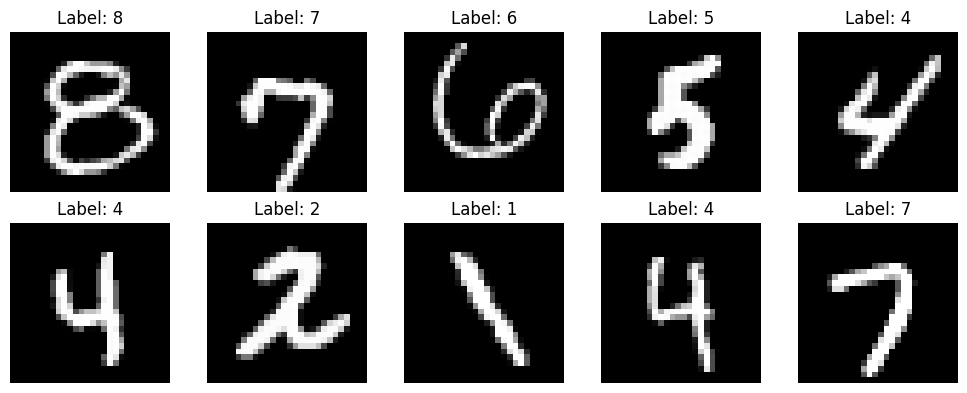

In [4]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # X_train[i] 是一个784维的向量，我们需要将其变回28x28的矩阵来显示
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    # y_train[i] 是独热编码向量，我们用argmax找到最大值的索引，即为数字标签
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 第2步：定义神经网络结构和函数

我们将构建一个包含一个隐藏层的简单神经网络。
**结构:** `输入层 (784) -> 隐藏层 (128) -> 输出层 (10)`

In [5]:
# --- 网络结构定义 ---
input_size = 784  # 28x28=784
hidden_size = 128 # 隐藏层神经元数量，这是一个可以调整的超参数
output_size = 10  # 0-9共10个类别

# --- 初始化参数 ---
# 我们需要两组权重和偏置：输入层到隐藏层(W1, b1)，隐藏层到输出层(W2, b2)
# 初始化为小的随机数，有助于打破对称性，让不同的神经元学习不同的特征
W1 = np.random.randn(hidden_size, input_size) * 0.01
b1 = np.zeros((hidden_size, 1))
W2 = np.random.randn(output_size, hidden_size) * 0.01
b2 = np.zeros((output_size, 1))

# --- 激活函数 ---
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

# Softmax函数用于多分类问题，它将输出层的原始值(logits)转换为概率分布
def softmax(Z):
    # 减去最大值是为了数值稳定性，防止exp()溢出
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

# --- 损失函数 ---
# 交叉熵损失函数 (Cross-Entropy Loss)，是分类问题中最常用的损失函数
def cross_entropy_loss(A, Y):
    m = Y.shape[1]
    # A是预测概率，Y是真实标签(独热编码)
    loss = -1/m * np.sum(Y * np.log(A + 1e-8)) #加上一个很小的数1e-8防止log(0)
    return loss

## 第3步：训练过程 (前向传播 + 反向传播)

这是最核心的部分。我们将把之前学的所有理论都用代码实现出来。

In [6]:
def forward_propagation(X, W1, b1, W2, b2):
    # X的形状是 (784, m)，m是样本数量。我们需要转置一下以进行计算
    X = X.T # 形状变为 (784, m)
    
    # 隐藏层计算
    Z1 = W1 @ X + b1       # (128, 784) @ (784, m) -> (128, m)
    A1 = relu(Z1)          # (128, m)
    
    # 输出层计算
    Z2 = W2 @ A1 + b2      # (10, 128) @ (128, m) -> (10, m)
    A2 = softmax(Z2)       # (10, m)
    
    # 返回所有中间结果，因为反向传播需要它们
    return Z1, A1, Z2, A2

def backward_propagation(X, Y, Z1, A1, Z2, A2, W1, W2):
    X = X.T # (784, m)
    Y = Y.T # (10, m)
    m = X.shape[1] # 样本数量
    
    # --- 输出层梯度 ---
    # 这是交叉熵损失和Softmax激活函数组合后的梯度，是一个简化的形式
    dZ2 = A2 - Y                                 # (10, m)
    dW2 = 1/m * dZ2 @ A1.T                       # (10, m) @ (m, 128) -> (10, 128)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True) # (10, 1)
    
    # --- 隐藏层梯度 ---
    dA1 = W2.T @ dZ2                             # (128, 10) @ (10, m) -> (128, m)
    dZ1 = dA1 * relu_derivative(Z1)              # (128, m)
    dW1 = 1/m * dZ1 @ X.T                        # (128, m) @ (m, 784) -> (128, 784)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True) # (128, 1)
    
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    return W1, b1, W2, b2

## 第4步：开始训练！

我们将所有部分组合起来，进行迭代训练。

In [8]:
# 设置超参数
learning_rate = 0.1
epochs = 100
batch_size = 256

loss_history = []
accuracy_history = []

print("开始训练...")
for i in range(epochs):
    # Mini-batch梯度下降
    for j in range(0, X_train.shape[0], batch_size):
        # 获取一个小批量数据
        X_batch = X_train[j:j+batch_size]
        Y_batch = y_train[j:j+batch_size]
        
        # 1. 前向传播
        Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W2, b2)
        
        # 2. 反向传播
        dW1, db1, dW2, db2 = backward_propagation(X_batch, Y_batch, Z1, A1, Z2, A2, W1, W2)
        
        # 3. 更新参数
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
    # 在每个epoch结束时，计算并记录损失和准确率
    _, _, _, A2_full = forward_propagation(X_train, W1, b1, W2, b2)
    loss = cross_entropy_loss(A2_full, y_train.T)
    loss_history.append(loss)
    
    predictions = np.argmax(A2_full, axis=0)
    labels = np.argmax(y_train.T, axis=0)
    accuracy = np.mean(predictions == labels)
    accuracy_history.append(accuracy)
    
    if (i + 1) % 50 == 0:
        print(f"Epoch {i+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

print("训练完毕!")

开始训练...
Epoch 50/100, Loss: 0.0110, Accuracy: 0.9990
Epoch 100/100, Loss: 0.0061, Accuracy: 0.9997
训练完毕!


### 可视化学习过程

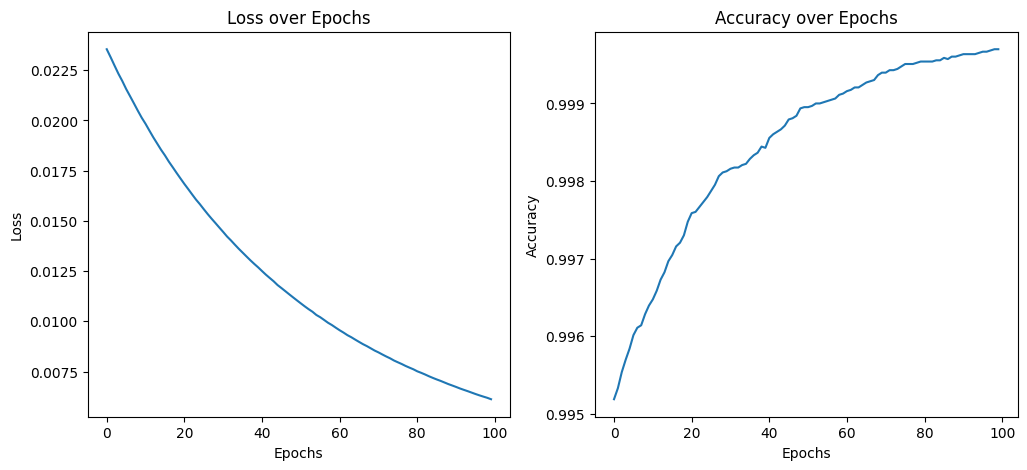

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_history)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

## 第5步：评估模型并进行预测

现在，让我们用从未见过的测试集来检验我们的模型效果如何。

In [10]:
# 在测试集上进行前向传播
_, _, _, A2_test = forward_propagation(X_test, W1, b1, W2, b2)

# 计算测试准确率
test_predictions = np.argmax(A2_test, axis=0)
test_labels = np.argmax(y_test.T, axis=0)
test_accuracy = np.mean(test_predictions == test_labels)

print(f"在测试集上的最终准确率: {test_accuracy * 100:.2f}%")

在测试集上的最终准确率: 97.36%


### 可视化单个预测
让我们随机选一张测试图片，看看模型的预测结果、以及它对每个数字的“信心”（概率分布）。

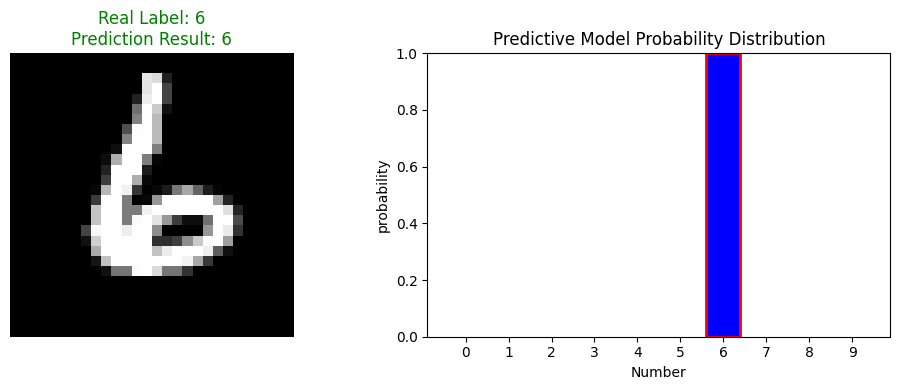

In [12]:
def predict_and_visualize(index, X_data, y_data, W1, b1, W2, b2):
    # 获取单个样本
    image = X_data[index]
    label = np.argmax(y_data[index])
    
    # 需要将(784,)的向量变成(784, 1)的矩阵以进行计算
    image_col = image.reshape(-1, 1)
    
    # 前向传播
    Z1 = W1 @ image_col + b1
    A1 = relu(Z1)
    Z2 = W2 @ A1 + b2
    A2 = softmax(Z2)
    
    prediction = np.argmax(A2)
    
    # 绘图
    plt.figure(figsize=(10, 4))
    
    # 显示图片和预测结果
    plt.subplot(1, 2, 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"Real Label: {label}\nPrediction Result: {prediction}", color=('green' if label == prediction else 'red'))
    plt.axis('off')
    
    # 显示概率分布
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(10), A2.flatten(), color='skyblue')
    plt.xlabel('Number')
    plt.ylabel('probability')
    plt.title('Predictive Model Probability Distribution')
    plt.xticks(range(10))
    plt.ylim(0, 1)
    bars[prediction].set_color('blue')
    bars[label].set_edgecolor('red')
    bars[label].set_linewidth(2)
    
    plt.tight_layout()
    plt.show()

# 随机选择一个测试样本进行预测
random_index = np.random.randint(0, X_test.shape[0])
predict_and_visualize(random_index, X_test, y_test, W1, b1, W2, b2)

## 总结

太棒了！我们从零开始，只用Numpy就构建并训练了一个完整的神经网络，并且在真实数据集上取得了相当不错的性能（通常能达到90%以上的准确率）。

通过这个过程，你不仅实践了之前学到的所有理论，更重要的是，你亲手揭开了深度学习的“黑箱”。现在，你已经拥有了深入理解更复杂模型（如CNN、RNN、Transformers）的坚实基础。